In [1]:
# Import Statements
import json
import os
import re

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.feature_selection import mutual_info_classif
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import classification_report
from palettable.colorbrewer.qualitative import Pastel1_7
from PIL import Image

In [2]:
# Load user metadata from JSON file
user_data = []
with open('C:path\\manifest.jl', 'r') as json_file:
    for line in json_file:
        user_data.append(json.loads(line))
        # Check the number of users in the dataset
print(f"Number of users: {len(user_data)}")

Number of users: 200


{'user_id_str': 1032653820, 'num_tweets': 3866, 'gender_human': 'M'}            0.005
{'user_id_str': 2466560409, 'num_tweets': 3100, 'gender_human': 'F'}            0.005
{'user_id_str': 104025767, 'num_tweets': 3168, 'gender_human': 'F'}             0.005
{'user_id_str': 746480464517464064, 'num_tweets': 2842, 'gender_human': 'F'}    0.005
{'user_id_str': 23719482, 'num_tweets': 3200, 'gender_human': 'F'}              0.005
                                                                                ...  
{'user_id_str': 1715181804, 'num_tweets': 3082, 'gender_human': 'M'}            0.005
{'user_id_str': 33395496, 'num_tweets': 3196, 'gender_human': 'M'}              0.005
{'user_id_str': 860111966, 'num_tweets': 3165, 'gender_human': 'M'}             0.005
{'user_id_str': 18981284, 'num_tweets': 7231, 'gender_human': 'M'}              0.005
{'user_id_str': 24487757, 'num_tweets': 3190, 'gender_human': 'F'}              0.005
Length: 200, dtype: float64


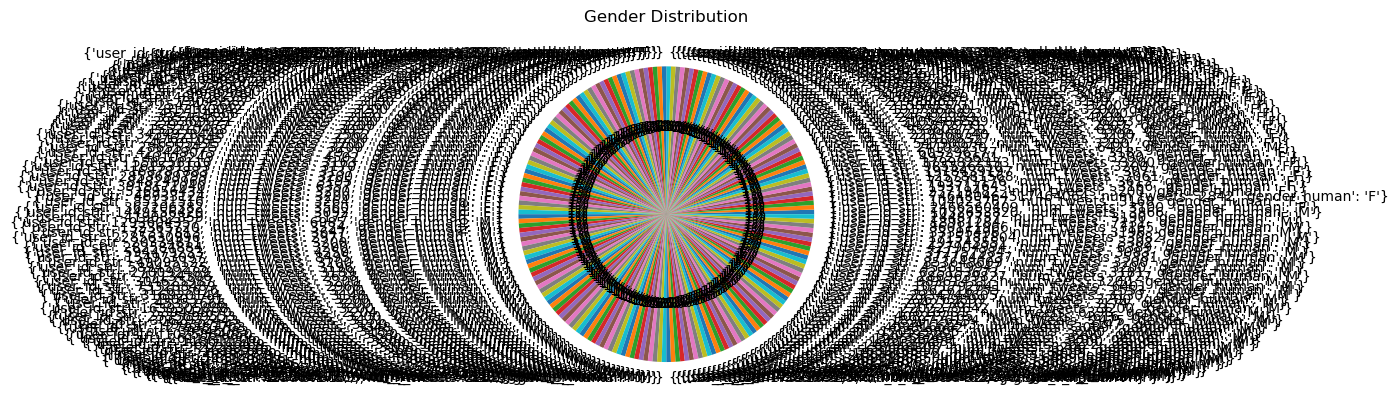

Number of users: 200


In [3]:
# Check the distribution of genders among users
gender_counts = pd.Series(user_data).value_counts('gender_human')
print(gender_counts)

# Visualize the gender distribution using a pie chart
gender_counts.plot.pie(autopct="%1.0f%%", labels=gender_counts.index, title="Gender Distribution")
plt.show()

# Check the number of users in the dataset
print(f"Number of users: {len(user_data)}")

In [4]:
# Data Preprocessing
# Load tweets for each user
tweet_data = {}
for filename in os.listdir('C:path\\tweet_files'):
    user_id = filename.split('.')[0]
    with open(f'C:path\\ds_interview\\tweet_files/{filename}', 'r', encoding='utf-8') as f:
        tweets = f.readlines()
    tweet_data[user_id] = tweets

# Combine tweets for each user
user_tweets = {}
for user_id, tweets in tweet_data.items():
    user_tweets[user_id] = ' '.join(tweets)

# Text Preprocessing
# Remove punctuation and convert text to lowercase
for user_id, text in user_tweets.items():
    user_tweets[user_id] = re.sub(r'[^\w\s]', '', text).lower()

# Remove stop words
stop_words = set(stopwords.words('english'))
for user_id, text in user_tweets.items():
    user_tweets[user_id] = ' '.join([word for word in text.split() if word not in stop_words])

In [5]:
# Feature Extraction
# Create a DataFrame with user IDs, tweets, and gender labels
user_ids = [user.get('user_id_str') or user.get('id') for user in user_data]
tweets = list(user_tweets.values())  # Convert values to list
genders = [user.get('gender_human') or 'Unknown' for user in user_data]

data = pd.DataFrame({'user_id': user_ids, 'tweets': tweets, 'gender': genders})

# Extract TF-IDF features from tweets
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['tweets'])

# Explain dataset structure
print("\nDataset Structure Explanation:")
print("-------------------------------")
print("1. 'user_id_str': User ID")
print("2. 'num_tweets': Number of tweets by the user")
print("3. 'gender_human': Gender of the user")
print("-------------------------------")


Dataset Structure Explanation:
-------------------------------
1. 'user_id_str': User ID
2. 'num_tweets': Number of tweets by the user
3. 'gender_human': Gender of the user
-------------------------------


In [6]:
# Generate and analyze metafeatures
# Add metafeatures to the dataset
data['num_words'] = data['tweets'].apply(lambda x: len(x.split()))
data['num_unique_words'] = data['tweets'].apply(lambda x: len(set(x.split())))
data['avg_word_length'] = data['tweets'].apply(lambda x: np.mean([len(word) for word in x.split()]))

# Display summary statistics of metafeatures
print("\nSummary Statistics of Metafeatures:")
print(data[['num_words', 'num_unique_words', 'avg_word_length']].describe())


Summary Statistics of Metafeatures:
          num_words  num_unique_words  avg_word_length
count  2.000000e+02        200.000000       200.000000
mean   1.199188e+06      34807.845000         9.437552
std    5.085161e+05      18372.743589         0.226333
min    5.504270e+05      12885.000000         8.915047
25%    8.715695e+05      22956.250000         9.306495
50%    1.046803e+06      28901.500000         9.398298
75%    1.390074e+06      40276.750000         9.531226
max    3.293585e+06     109883.000000        10.661208


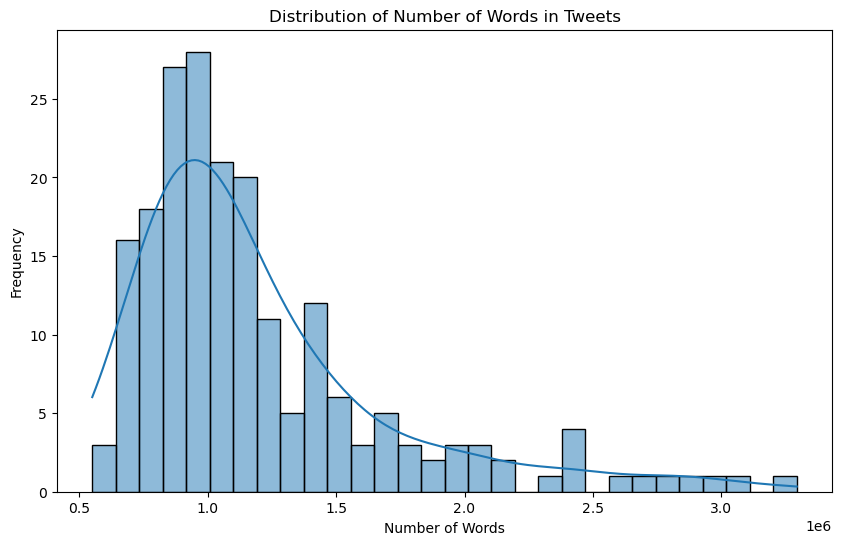

In [7]:
# Visualize the dataset extensively using Matplotlib, seaborn, and Plotly
# Visualize the distribution of the number of words in tweets
plt.figure(figsize=(10, 6))
sns.histplot(data['num_words'], bins=30, kde=True)
plt.title('Distribution of Number of Words in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

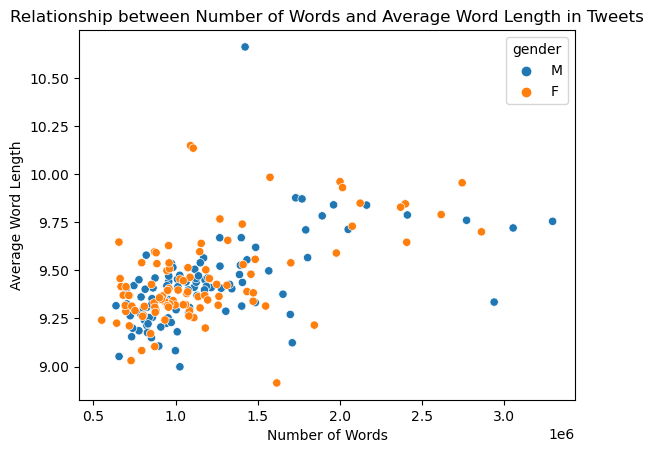

In [8]:
# Visualize the relationship between number of words and average word length
sns.scatterplot(x='num_words', y='avg_word_length', hue='gender', data=data)
plt.title('Relationship between Number of Words and Average Word Length in Tweets')
plt.xlabel('Number of Words')
plt.ylabel('Average Word Length')
plt.show()

In [9]:
# Use Plotly to create an interactive scatter plot
fig = px.scatter(data, x='num_words', y='avg_word_length', color='gender', title='Interactive Scatter Plot',
                 labels={'num_words': 'Number of Words', 'avg_word_length': 'Average Word Length'})
fig.show()

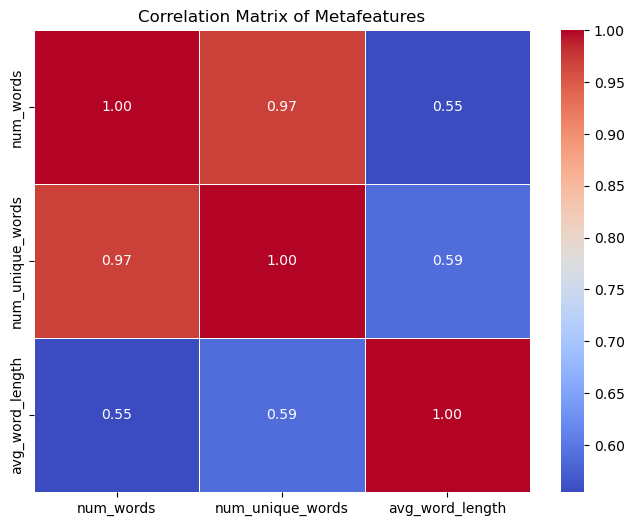

In [10]:
# Additional Visualizations
# Correlation Matrix
correlation_matrix = data[['num_words', 'num_unique_words', 'avg_word_length']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=.5)
plt.title('Correlation Matrix of Metafeatures')
plt.show()

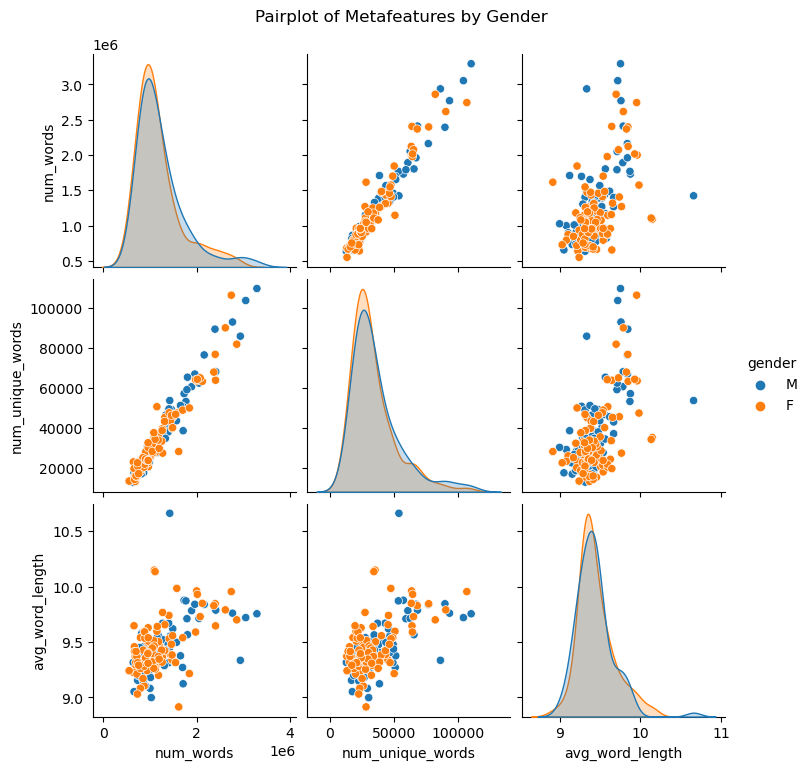

In [11]:
# Pairplot for selected features
sns.pairplot(data[['num_words', 'num_unique_words', 'avg_word_length', 'gender']], hue='gender')
plt.suptitle('Pairplot of Metafeatures by Gender', y=1.02)
plt.show()

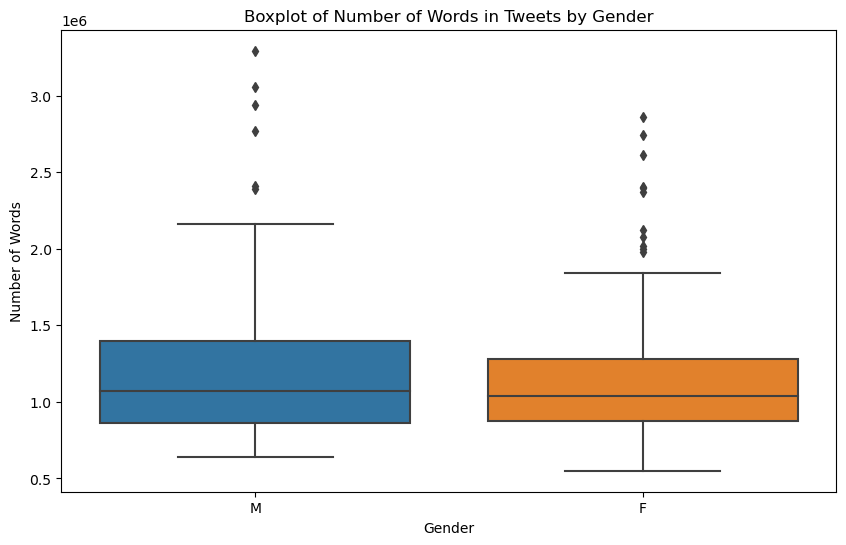

In [12]:
# Boxplot of word count by gender
plt.figure(figsize=(10, 6))
sns.boxplot(x='gender', y='num_words', data=data)
plt.title('Boxplot of Number of Words in Tweets by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of Words')
plt.show()

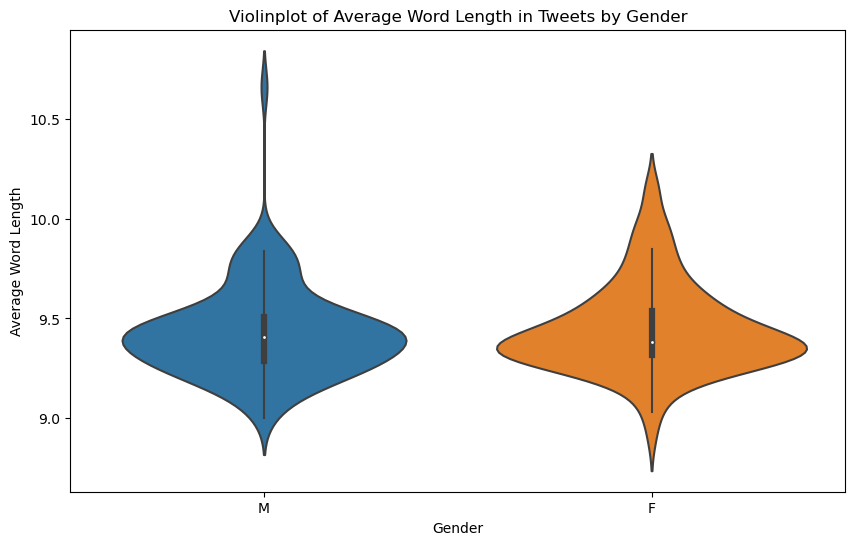

In [13]:
# Violinplot of word length by gender
plt.figure(figsize=(10, 6))
sns.violinplot(x='gender', y='avg_word_length', data=data)
plt.title('Violinplot of Average Word Length in Tweets by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Word Length')
plt.show()

In [22]:
# **Model Training and Evaluation**

# Split Data into Training and Testing Sets
X_train, X_test, y_train, y_test = train_test_split(X, data['gender'], test_size=0.2, random_state=42)

# Initialize the SGDClassifier with a sparse representation
model = SGDClassifier()

# Incremental training
batch_size = 100  # Adjust the batch size as needed
for i in range(0, X_train.shape[0], batch_size):
    X_batch = X_train[i:i+batch_size].toarray()
    y_batch = y_train[i:i+batch_size]
    model.partial_fit(X_batch, y_batch, classes=np.unique(y_train))

# Evaluate Model Performance
X_test = X_test.toarray()  # Convert sparse matrix to dense array
y_pred = model.predict(X_test)

# Use zero_division='warn' in classification_report
print(classification_report(y_test, y_pred, zero_division='warn'))

              precision    recall  f1-score   support

           F       0.44      0.63      0.52        19
           M       0.46      0.29      0.35        21

    accuracy                           0.45        40
   macro avg       0.45      0.46      0.44        40
weighted avg       0.45      0.45      0.43        40



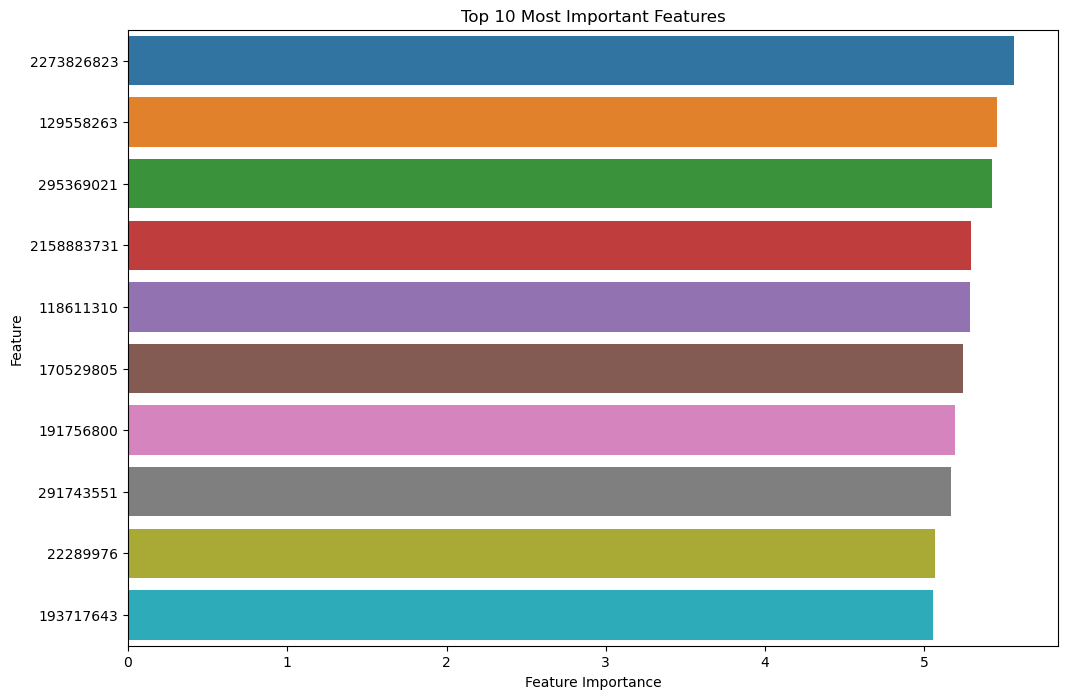

In [25]:
# Get feature importances from the trained model
coef = model.coef_.ravel()
important_features = pd.DataFrame({'feature': vectorizer.get_feature_names_out(), 'importance': coef})

# Sort features by importance
important_features.sort_values(by='importance', ascending=False, inplace=True)

# Visualize Feature Importance
plt.figure(figsize=(12, 8))
sns.barplot(x='importance', y='feature', data=important_features.head(10))
plt.xlabel('Feature Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.show()